In [2]:
# Install mpich (required for mpi)
! sudo apt install libmpich-dev -y 
! pip install mpi4py


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  gfortran gfortran-9 hwloc-nox libgfortran-9-dev libhwloc-plugins libhwloc15
  libmpich12 libxnvctrl0 mpich
Suggested packages:
  gfortran-multilib gfortran-doc gfortran-9-multilib gfortran-9-doc
  libcoarrays-dev libhwloc-contrib-plugins mpich-doc
The following NEW packages will be installed:
  gfortran gfortran-9 hwloc-nox libgfortran-9-dev libhwloc-plugins libhwloc15
  libmpich-dev libmpich12 libxnvctrl0 mpich
0 upgraded, 10 newly installed, 0 to remove and 75 not upgraded.
Need to get 12.3 MB of archives.
After this operation, 52.1 MB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libxnvctrl0 555.42.02-0ubuntu1 [21.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libgfortran-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [685 kB]
Get:3 http://archive.ub

In [7]:
from mpi4py import MPI
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt



In [26]:
with open("mpi_example_1.py", "w") as f:
    f.write("""
from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# passing MPI datatypes explicitly
if rank == 0:
    data = numpy.arange(10, dtype='i')
    comm.Send([data, MPI.INT], dest=1, tag=77)
    print(f"Rank {rank} sent {data}")
elif rank == 1:
    data = numpy.empty(10, dtype='i')
    comm.Recv([data, MPI.INT], source=0, tag=77)
    print(f"Rank {rank} sent {data}")


# automatic MPI datatype discovery
if rank == 0:
    data = numpy.arange(10, dtype=numpy.float64)
    comm.Send(data, dest=1, tag=13)
    print(f"Rank {rank} sent {data}")

elif rank == 1:
    data = numpy.empty(10, dtype=numpy.float64)
    comm.Recv(data, source=0, tag=13)
    print(f"Rank {rank} sent {data}")

    
    """)

!mpirun -np 4 python mpi_example_1.py


Rank 0 sent [0 1 2 3 4 5 6 7 8 9]
Rank 0 sent [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Rank 1 sent [0 1 2 3 4 5 6 7 8 9]
Rank 1 sent [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [29]:
with open("mpi_example.py", "w") as f:
    f.write("""
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

print(f'Hello from process {rank} out of {size} processes')

# 2. Scattering
if rank == 0:
    data_to_scatter = np.arange(size*2).reshape(size, 2)  # Create an array to scatter
    print(f'Process {rank} has data to scatter: {data_to_scatter}')
else:
    data_to_scatter = None

# Scatter data to all processes
received_scatter = comm.scatter(data_to_scatter, root=0)
print(f'Process {rank} received scatter data: {received_scatter}')

# 3. Gathering
# Each process doubles received data
data_to_gather = received_scatter * 2  
gathered_data = comm.gather(data_to_gather, root=0)

if rank == 0:
    print(f'Root process gathered data: {gathered_data}')
else:
    print(f'Process {rank} sent data to gather: {data_to_gather}')

# 4. Reducing
send_data = rank + 1  # Each process sends its rank + 1
reduced_sum = comm.reduce(send_data, op=MPI.SUM, root=0)

if rank == 0:
    print(f'Reduced sum of ranks: {reduced_sum}')
else:
    print(f'Process {rank} contributed to the reduction with value: {send_data}')

# 5. Allreduce
allreduced_sum = comm.allreduce(send_data, op=MPI.SUM)
print(f'Process {rank} allreduce sum of ranks: {allreduced_sum}')
""")

!mpirun -np 4 python mpi_example.py


Hello from process 0 out of 4 processes
Process 0 has data to scatter: [[0 1]
 [2 3]
 [4 5]
 [6 7]]
Process 0 received scatter data: [0 1]
Root process gathered data: [array([0, 2]), array([4, 6]), array([ 8, 10]), array([12, 14])]
Reduced sum of ranks: 10
Process 0 allreduce sum of ranks: 10
Hello from process 1 out of 4 processes
Process 1 received scatter data: [2 3]
Process 1 sent data to gather: [4 6]
Process 1 contributed to the reduction with value: 2
Process 1 allreduce sum of ranks: 10
Hello from process 2 out of 4 processes
Process 2 received scatter data: [4 5]
Process 2 sent data to gather: [ 8 10]
Process 2 contributed to the reduction with value: 3
Process 2 allreduce sum of ranks: 10
Hello from process 3 out of 4 processes
Process 3 received scatter data: [6 7]
Process 3 sent data to gather: [12 14]
Process 3 contributed to the reduction with value: 4
Process 3 allreduce sum of ranks: 10


In [75]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

print('rank', comm.Get_rank())
print('SIZE', size)


if torch.cuda.is_available():
    device = torch.device(f'cuda:{rank}')
else:
    device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split the dataset into subsets for each rank (Shard)
subset_indices = np.array_split(np.arange(len(train_dataset)), size)
train_subset = Subset(train_dataset, subset_indices[rank])
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

model = Net().to(device)

# Broadcast the model's initial weights
for param in model.parameters():
    comm.Bcast(param.data, root=0)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []
test_accuracies = []

def train(epoch):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Average gradients
        for param in model.parameters():
            comm.Allreduce(MPI.IN_PLACE, param.grad.data, op=MPI.SUM)
            param.grad.data /= size
        
        optimizer.step()
        epoch_loss += loss.item()
        
#         if batch_idx % 10 == 0 and rank == 0:
#             print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    train_losses.append(epoch_loss / len(train_loader))

# Test function
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    if rank == 0:
#         print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
        test_accuracies.append(accuracy)

EPOCHS = 5
for epoch in range(1, EPOCHS+1):
    train(epoch)
    test()


rank 0
SIZE 1


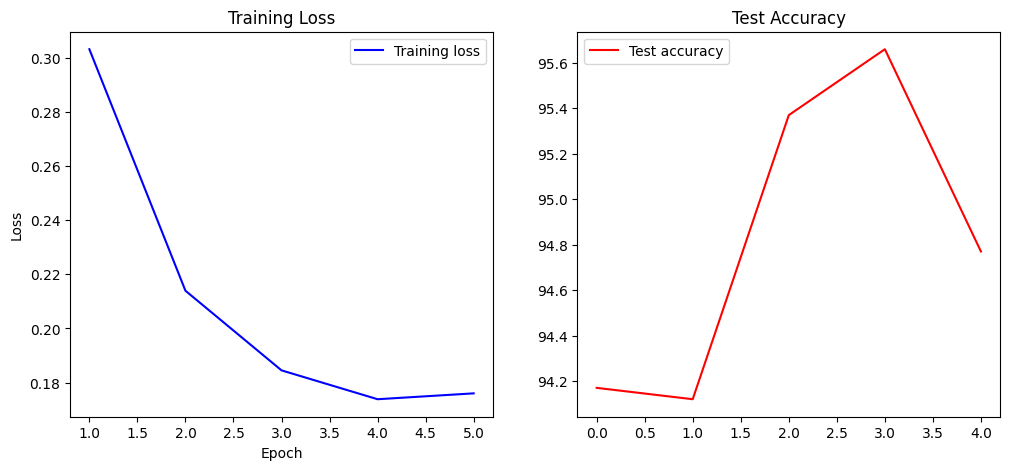

In [83]:

# Plot the learning curves
if rank == 0:
    epochs = range(1, EPOCHS+1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, 'r-', label='Test accuracy')
    plt.title('Test Accuracy')
    plt.legend()

    plt.show()


# Using Pytorch implementation of Multiple GPUs with MPI background: https://pytorch.org/tutorials/intermediate/dist_tuto.html?highlight=mpi

As comment in the pytorch page, working with MPI in Pytorch has to recompile the Pytorch, which I couldn't acheive here on the Kaggle notebook:

> Unfortunately, PyTorch’s binaries cannot include an MPI implementation and we’ll have to recompile it by hand. Fortunately, this process is fairly simple given that upon compilation, PyTorch will look by itself for an available MPI implementation. The following steps install the MPI backend, by installing PyTorch from source.
> 

So, with pytorch, I couldn't use MPI in MultipleGPUs. I tried Keras as well, but I wasn't successfull

# Adam implementation

Here we use a dummy model data to test

In [41]:
! pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 7.3 MB/s eta 0:00:00:00:0100:01


In [69]:
import torch
import triton
import triton.language as tl

@triton.jit
def adam_update_kernel(
    param_ptr, grad_ptr, m_ptr, v_ptr, param_size, 
    lr, beta1, beta2, epsilon, beta1_correction, beta2_correction, BLOCK_SIZE: tl.constexpr
):
    # Block index
    block_idx = tl.program_id(axis=0)
    
    # Position of the first element of the block
    block_start = block_idx * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    
    # Load data
    param = tl.load(param_ptr + offsets, mask=offsets < param_size, other=0.0)
    grad = tl.load(grad_ptr + offsets, mask=offsets < param_size, other=0.0)
    m = tl.load(m_ptr + offsets, mask=offsets < param_size, other=0.0)
    v = tl.load(v_ptr + offsets, mask=offsets < param_size, other=0.0)
    
    # Update m and v
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * grad * grad
    
    # Compute bias-corrected m and v
    m_hat = m / beta1_correction
    v_hat = v / beta2_correction
    
    # Compute the parameter update
    update = -lr * m_hat / (tl.sqrt(v_hat) + epsilon)
    
    # Apply the update
    param = param + update
    
    # Store results
    tl.store(param_ptr + offsets, param, mask=offsets < param_size)
    tl.store(m_ptr + offsets, m, mask=offsets < param_size)
    tl.store(v_ptr + offsets, v, mask=offsets < param_size)


In [70]:
class TritonAdam(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        defaults = dict(lr=lr, betas=betas, eps=eps)
        super(TritonAdam, self).__init__(params, defaults)

    def triton_adam(self, param, grad, m, v, lr, beta1, beta2, epsilon, step):
        beta1_correction = 1 - beta1 ** step
        beta2_correction = 1 - beta2 ** step
        BLOCK_SIZE = 1024
        grid = lambda meta: (triton.cdiv(param.numel(), meta['BLOCK_SIZE']),)
        adam_update_kernel[grid](
            param, grad, m, v, param.numel(), 
            lr, beta1, beta2, epsilon, beta1_correction, beta2_correction,
            BLOCK_SIZE=BLOCK_SIZE
        )

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['betas']
            eps = group['eps']
            
            for param in group['params']:
                if param.grad is None:
                    continue
                grad = param.grad.data
                state = self.state[param]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(param.data)
                    state['exp_avg_sq'] = torch.zeros_like(param.data)

                state['step'] += 1
                step = state['step']
                exp_avg = state['exp_avg']
                exp_avg_sq = state['exp_avg_sq']

                self.triton_adam(param.data, grad, exp_avg, exp_avg_sq, lr, beta1, beta2, eps, step)

        return loss


In [74]:
import time
import torch.optim as optim

def benchmark(optimizer, model, criterion, data, target, epochs=100):
    start = time.time()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    return time.time() - start

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = torch.randn(1024, 1024, device=device)
target = torch.randn(1024, 1024, device=device)
model = torch.nn.Linear(1024, 1024).to(device)
criterion = torch.nn.MSELoss()

pytorch_adam = optim.Adam(model.parameters(), lr=1e-3)
pytorch_time = benchmark(pytorch_adam, model, criterion, data, target)
print(f"PyTorch Adam time: {pytorch_time:.4f} seconds")

triton_adam = TritonAdam(model.parameters(), lr=1e-3)
triton_time = benchmark(triton_adam, model, criterion, data, target)
print(f"Triton Adam time: {triton_time:.4f} seconds")


PyTorch Adam time: 0.1062 seconds
Triton Adam time: 0.1396 seconds
